# COR2mEg

Salut,

Je vous invite à aller regarder l'atlas des simulations de test  en AMIP pour la correction en ligne des biais (la correction est appliquée à la temperature et aux vents y compris dans la couche limite, mais avec une cste de temps de 1j)
https://vesg.ipsl.upmc.fr/thredds/fileServer/IPSLFS/fabric/lmdz/MultiSimu/BIAICOR3b.79/BIASGLOBDJF.html
COR2mE_1979_1988  simul. de reference
COR2mEg_1979_1988  simulation guidée
CCOR2mEgP_1979_1988  simulation corrigée

Pour Mickael la simulation guidée est la /gpfsstore/rech/gzi/rgzi019/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg
 Le biais froid hivernal est significativement réduit, mais je ne suis pas sure (ma géographie est nulle), que sur le Tibet il ne resiste pas.

F.

conda env: new `phd_v3` (in `envs/phd`)

## COR2mE
(pas la ref pour ici mais fera l'affaire)

- Jean-Zay STORE: `/gpfsstore/rech/gzi/rgzi019/IGCM_OUT/LMDZOR/PROD/amip/COR2mE`
- THREDDS: `/gpfsdsmnt/ipsl/dods/pub/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/`
- CICLAD: `/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/` 


## COR2mEg 

- Jean-Zay STORE: `/gpfsstore/rech/gzi/rgzi019/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg`
- THREDDS: `/gpfsdsmnt/ipsl/dods/pub/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/`
- CICLAD: `/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/` 


## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
xr.__version__

'0.16.0'

## Define paths

In [3]:
root = '/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/'
exp_ref = 'COR2mE'
exp_new = 'COR2mEg'

In [4]:
# !ls /thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/clim/LMDZOR-STD-REF/ATM/Analyse/TS_MO/

## Make function to get data

In [4]:
def get_data(list_vars, period, season, zone):
    """
        Get reference and new experiments + observations.

        Parameters
        ----------
        list_vars : list
            List of variables. Options are: 'frac_snow', 't2m', 'precip', 'ta'
        period : slice
            Period
        season : str
            Season (ex: 'annual', 'DJF', '1')
        zone : str
            Zone of study (ex: 'HMA', 'GLOB', 'NH')

        Returns
        -------
        ref, new, obs : list of Dataset
            List of reference and new experiments + observations regrided on model dataset (not 
            loaded) for each variable.
            
        clim_ref, clim_new, clim_obs : list of DataArray
            List of reference and new experiments + observations regrided on model climatologies
            for each variable.

        Example
        -------
        >>>  list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
                ['frac_snow', 't2m', 'precip'], slice('1981','1989'), 'annual', 'GLOB'
            )

    """
    
    list_ref = []
    list_new = []
    list_obs = []
    list_clim_ref = []
    list_clim_new = []
    list_clim_obs = []
       
    list_var_SRF = ['frac_snow']
    list_var_ATM = ['t2m', 'precip', 'ta']
    latlim, lonlim = u.get_zone(zone)

    for var in list_vars:

        print(
            f"""
    #############
    ### Variable: {var} 
    #############
            """
        )

        if var in list_var_SRF:
            component = 'SRF'
        elif var in list_var_ATM:
            component = 'ATM'
        else:
            raise ValueError(f"Invalid var argument: '{var}'. Valid names are: 'frac_snow'.")

        path = root+exp_ref+'/'+component+'/Analyse/TS_MO/'+exp_ref+'_19790101_19981231_1M_'+var+'.nc'
        print('Open reference simulation:\n'+path+'\n')
        ref = xr.open_dataset(path)[var]
        ref.attrs['title'] = exp_ref

        path = root+exp_new+'/'+component+'/Analyse/TS_MO/'+exp_new+'_19790101_20081231_1M_'+var+'.nc'
        print('Open new simulation:\n'+path+'\n')
        new = xr.open_dataset(path)[var]
        new.attrs['title'] = exp_new

        # Rename time dimension and sort latitude from -90 to 90
        ref = ref.rename({'time_counter': 'time'}).sortby('lat')
        new = new.rename({'time_counter': 'time'}).sortby('lat')

        # Compute climatolgy
        clim_ref = u.clim(
            ref.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='360_day')
        clim_ref.attrs['season'] = season
        clim_ref.attrs['zone'] = zone

        clim_new = u.clim(
            new.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='360_day')
        clim_new.attrs['season'] = season
        clim_new.attrs['zone'] = zone

        # Unit conversion
        if var in ['tas', 'tmp', 't2m', 'ta']:
            with xr.set_options(keep_attrs=True):
                clim_ref -= 273.15
                clim_new -= 273.15
            clim_ref.attrs['units'] = '°C'
            clim_new.attrs['units'] = '°C'

            if var in ['ta']:
                clim_ref = clim_ref.assign_coords({'plev': clim_ref.plev/100}).rename({'plev': 'level'})
                clim_new = clim_new .assign_coords({'plev': clim_new.plev/100}).rename({'plev': 'level'})

        elif var in ['pr', 'precip']:
            with xr.set_options(keep_attrs=True):
                clim_ref *= 86400
                clim_new *= 86400
            clim_ref.attrs['units'] = 'mm/day'
            clim_new.attrs['units'] = 'mm/day'

        # Get observations
        if var in ['snc', 'frac_snow']:
            obs_name = 'NH_SCE_CDR_HR'
            version = 'v01r00'
        elif var in ['tas', 'tmp', 't2m']:
            obs_name = 'CRU_TS'
            version = '4.04'
        elif var in ['pr', 'precip']:
            obs_name = 'APHRO_MA'
            version = 'V1101'
        elif var in ['ta']:
            obs_name = 'ERAI'
            version = ''

        obs = u.get_obs(obs_name, version, var, period=period, machine='CICLAD', regrid=clim_ref)
        clim_obs = u.clim(
            obs.sel(time=period, lat=latlim, lon=lonlim), season=season, calendar='standard')
        
        list_ref.append(ref)
        list_new.append(new)
        list_obs.append(obs)
        list_clim_ref.append(clim_ref)
        list_clim_new.append(clim_new)
        list_clim_obs.append(clim_obs)
               
    return list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs

## Plot differences and compare to observation

### HMA

#### Get data

In [40]:
# list_vars = ['frac_snow']
list_vars = ['frac_snow', 't2m', 'precip']

# Period for climatologies (removing first year spin-up)
period = slice('1981','1998')
season = 'annual'
zone = 'HMA'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: frac_snow 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/SRF/Analyse/TS_MO/COR2mE_19790101_19981231_1M_frac_snow.nc

Open new simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/SRF/Analyse/TS_MO/COR2mEg_19790101_20081231_1M_frac_snow.nc

Get observation: NH_SCE_CDR_HR
/data/mlalande/RUTGERS/G10035-rutgers-nh-24km-weekly-sce-v01r00-19800826-20200831_newer_without_xy.nc



/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Reuse existing file: bilinear_709x709_43x36_peri.nc

    #############
    ### Variable: t2m 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/ATM/Analyse/TS_MO/COR2mE_19790101_19981231_1M_t2m.nc

Open new simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/ATM/Analyse/TS_MO/COR2mEg_19790101_20081231_1M_t2m.nc

Get observation: CRU_TS
/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc

Reuse existing file: bilinear_360x720_43x36_peri.nc

    #############
    ### Variable: precip 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/ATM/Analyse/TS_MO/COR2mE_19790101_19981231_1M_precip.nc

Open new simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/ATM/Analyse/TS_MO/COR2mEg_19790101_20081231_1M_precip.nc

Get observation: APHRO_MA
/data/mlalande/APHRODITE/APHRO_MA_050deg_V1101.*.nc

Get observation: APHRO

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Reuse existing file: bilinear_140x180_43x36.nc


#### Make plots

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


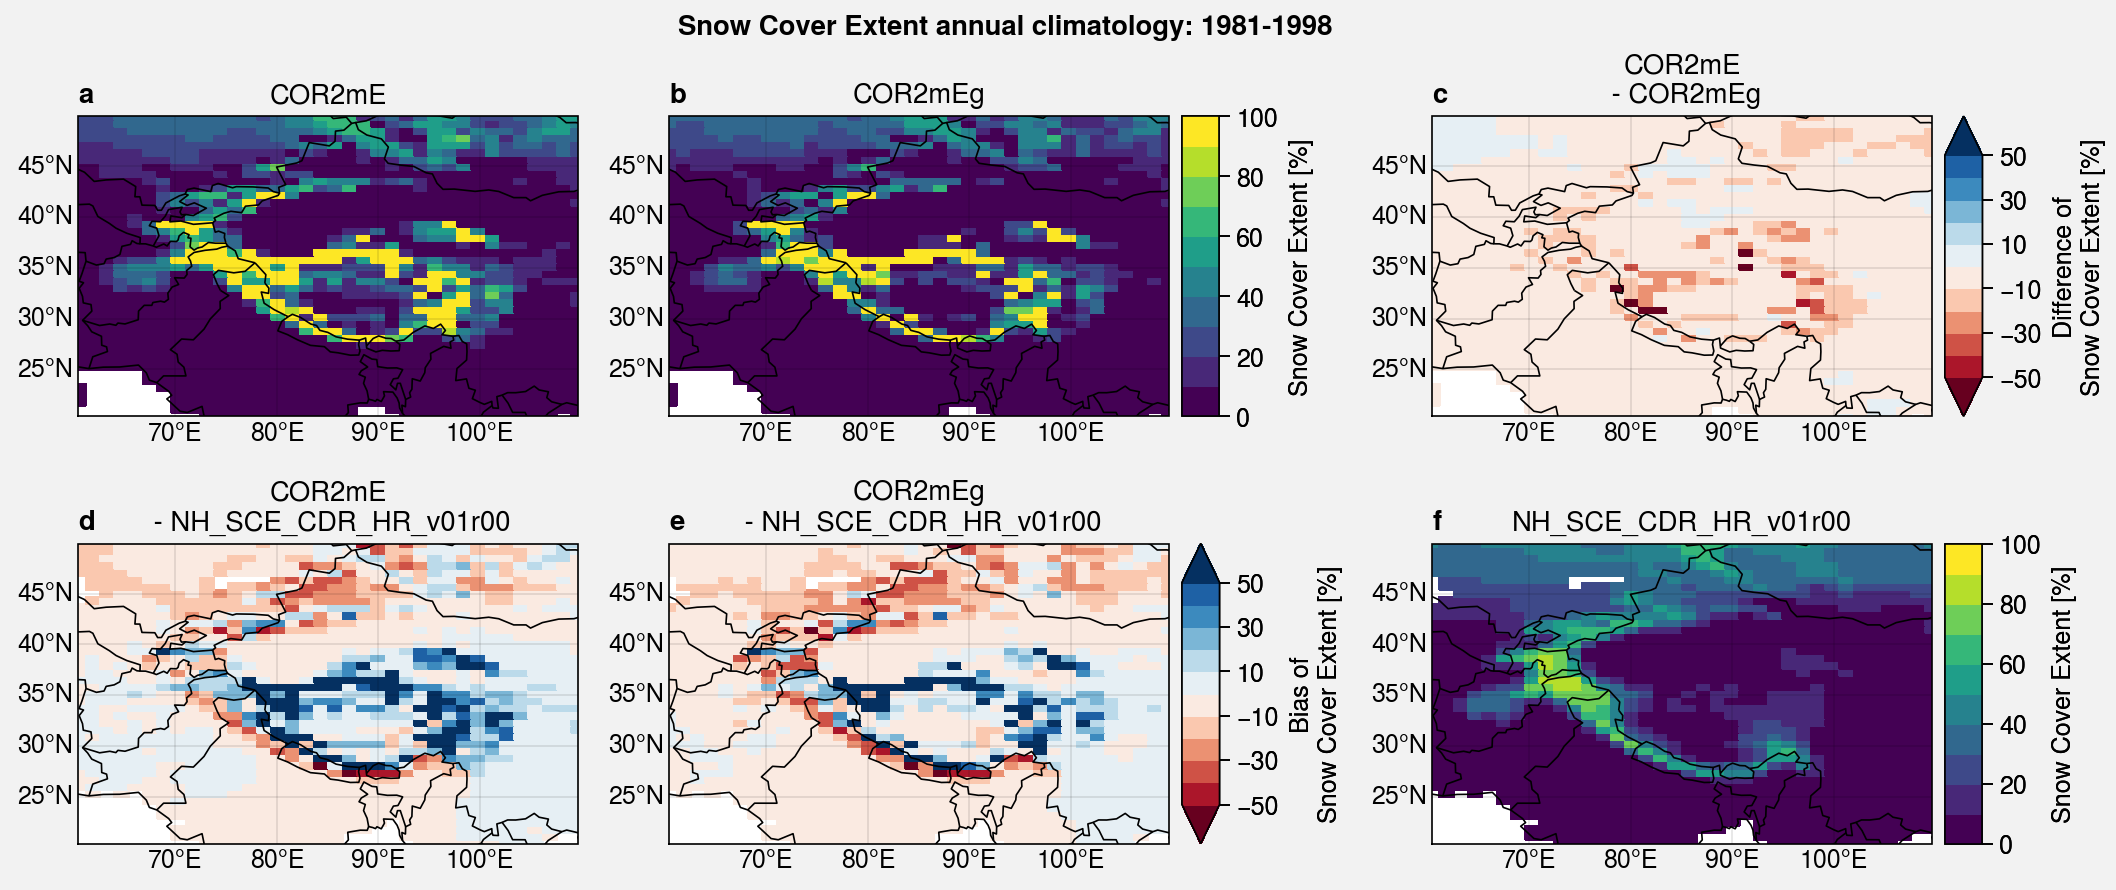

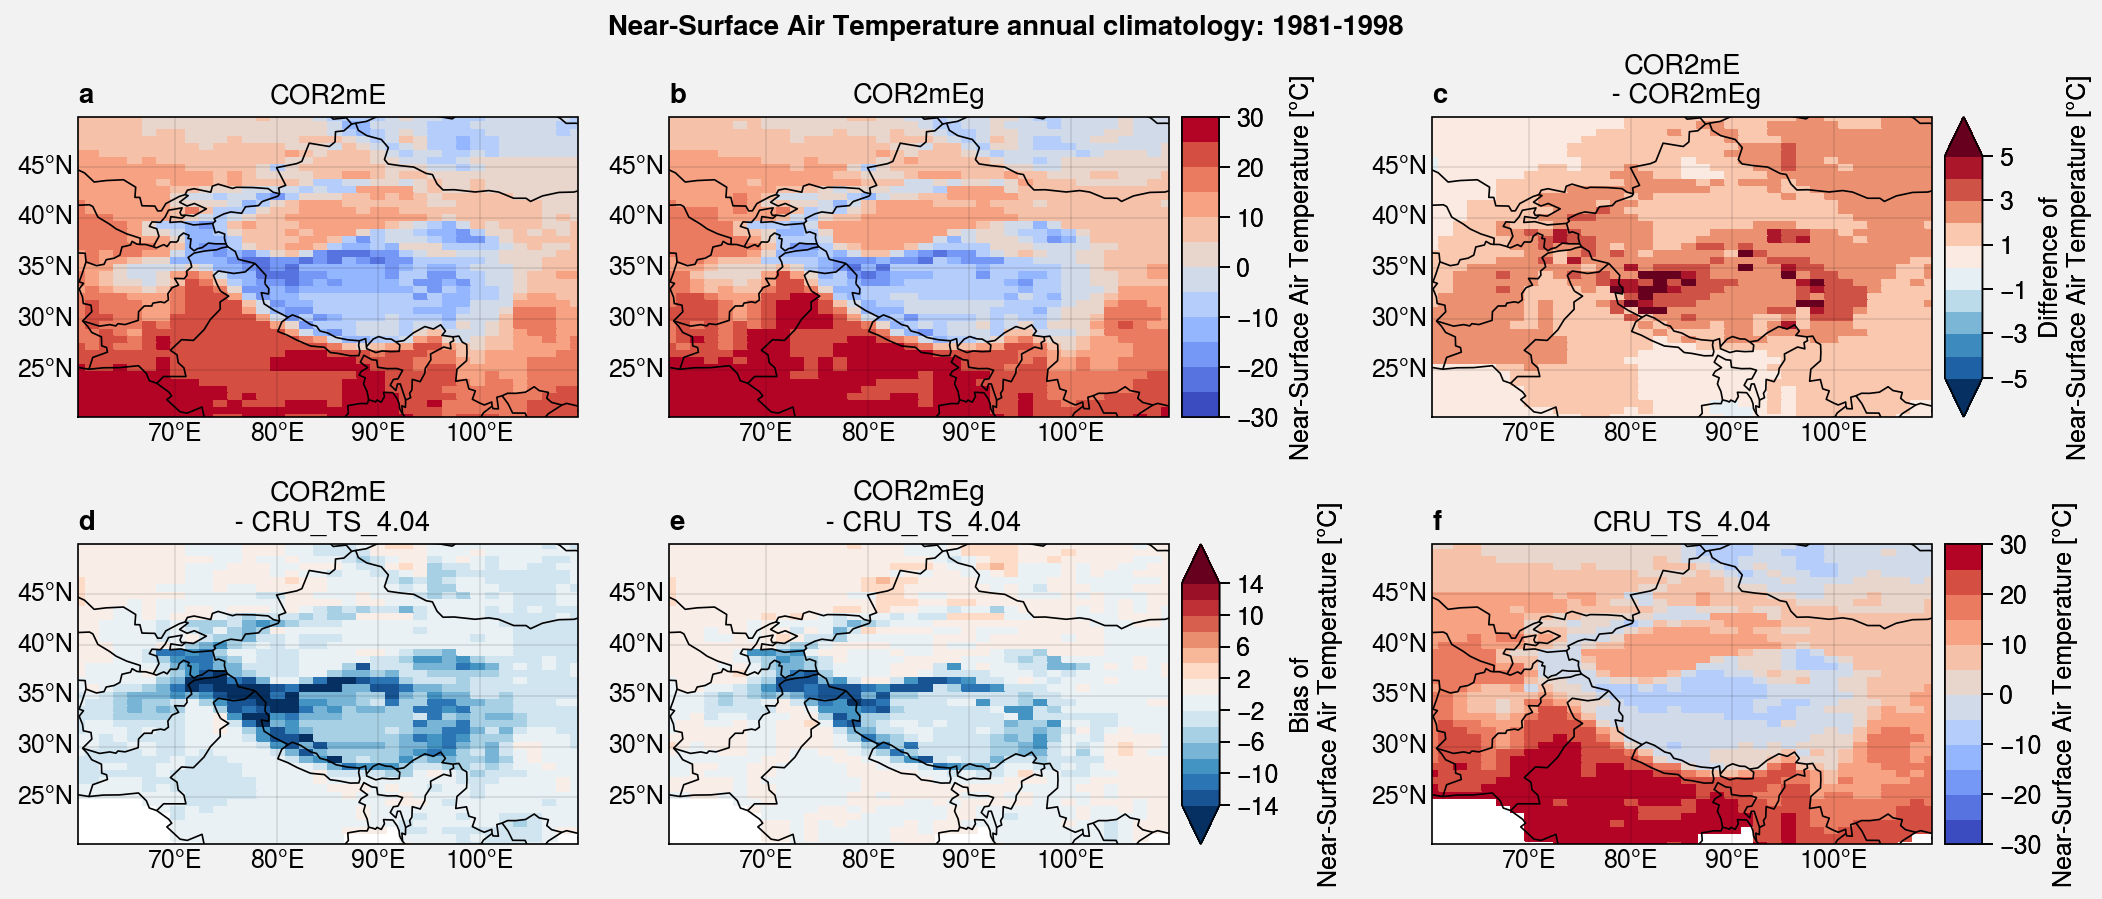

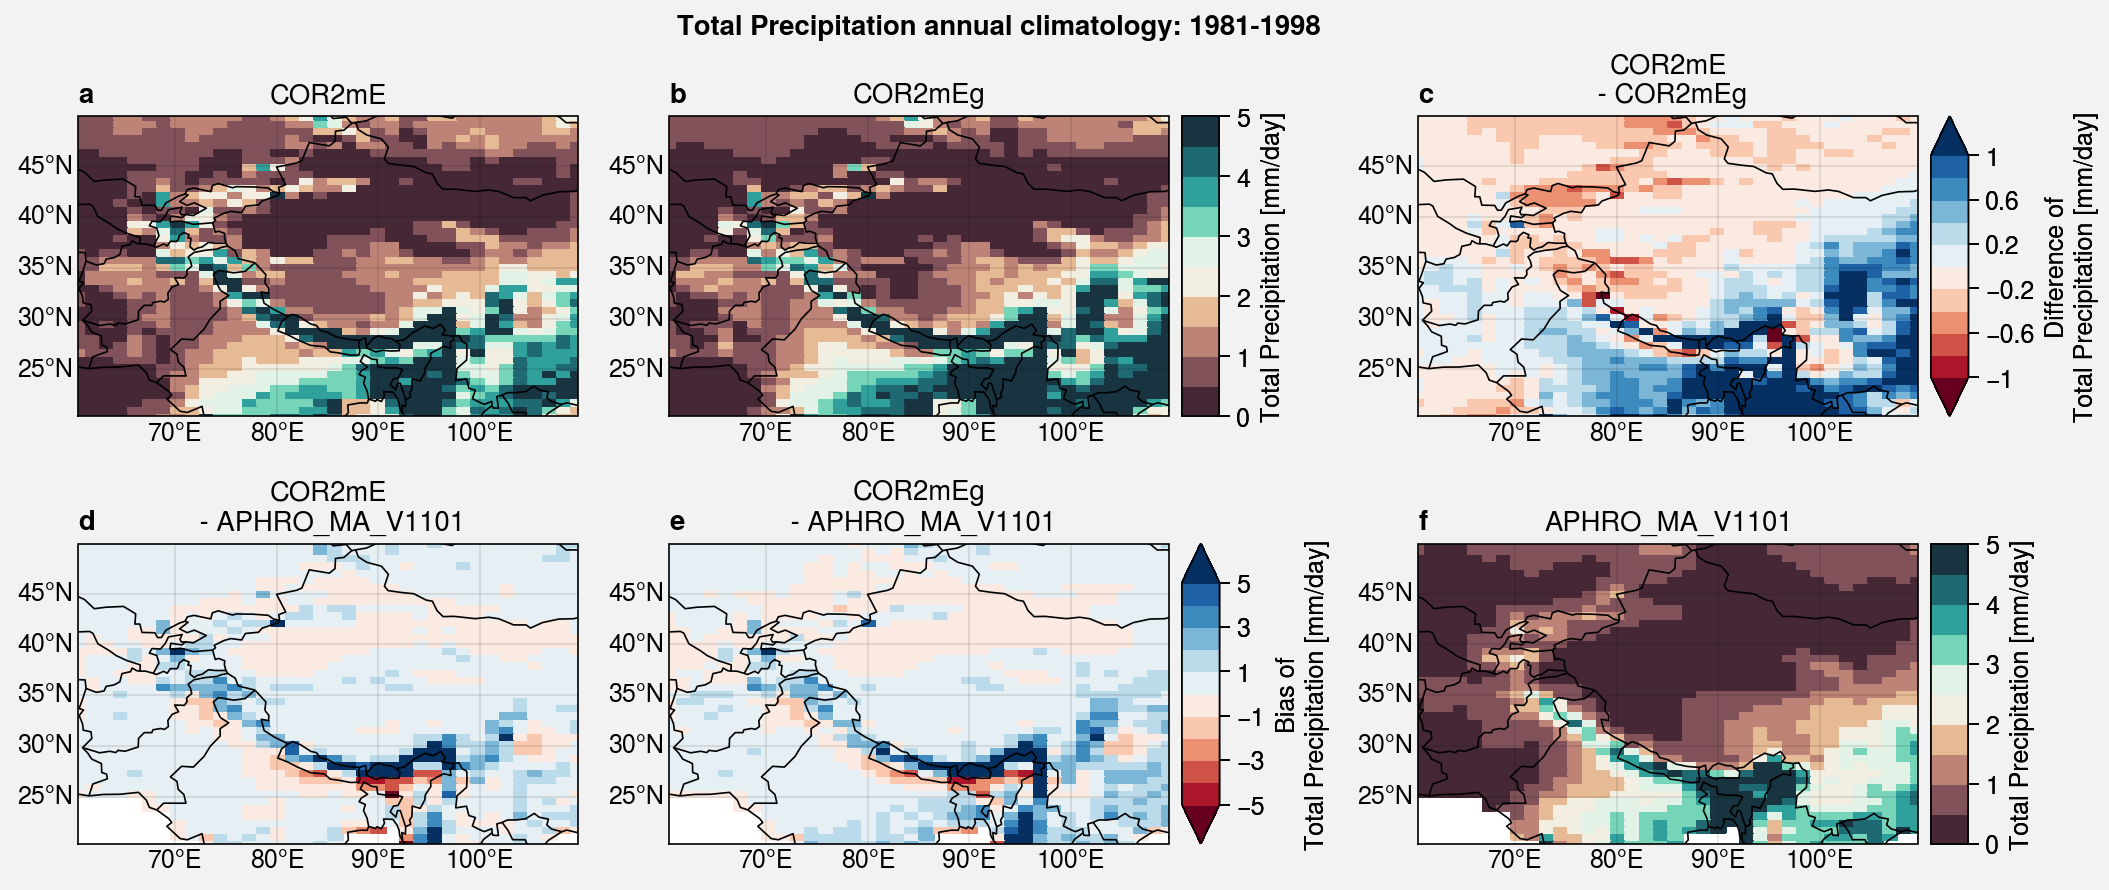

In [42]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

### Northern Hemisphere

#### Get data

In [12]:
# list_vars = ['frac_snow']
list_vars = ['frac_snow', 't2m']

# Period for climatologies (removing first year spin-up)
period = slice('1981','1998')
season = 'annual'
zone = 'NH'

list_ref, list_new, list_obs, list_clim_ref, list_clim_new, list_clim_obs = get_data(
    list_vars, period, season, zone)


    #############
    ### Variable: frac_snow 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/SRF/Analyse/TS_MO/COR2mE_19790101_19981231_1M_frac_snow.nc

Open new simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/SRF/Analyse/TS_MO/COR2mEg_19790101_20081231_1M_frac_snow.nc

Get observation: NH_SCE_CDR_HR
/data/mlalande/RUTGERS/G10035-rutgers-nh-24km-weekly-sce-v01r00-19800826-20200831_newer_without_xy.nc



/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Create weight file: bilinear_709x709_129x256_peri.nc

    #############
    ### Variable: t2m 
    #############
            
Open reference simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mE/ATM/Analyse/TS_MO/COR2mE_19790101_19981231_1M_t2m.nc

Open new simulation:
/thredds/idris/work/ufz23bm/IGCM_OUT/LMDZOR/PROD/amip/COR2mEg/ATM/Analyse/TS_MO/COR2mEg_19790101_20081231_1M_t2m.nc

Get observation: CRU_TS
/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc

Reuse existing file: bilinear_360x720_129x256_peri.nc


#### Make plots

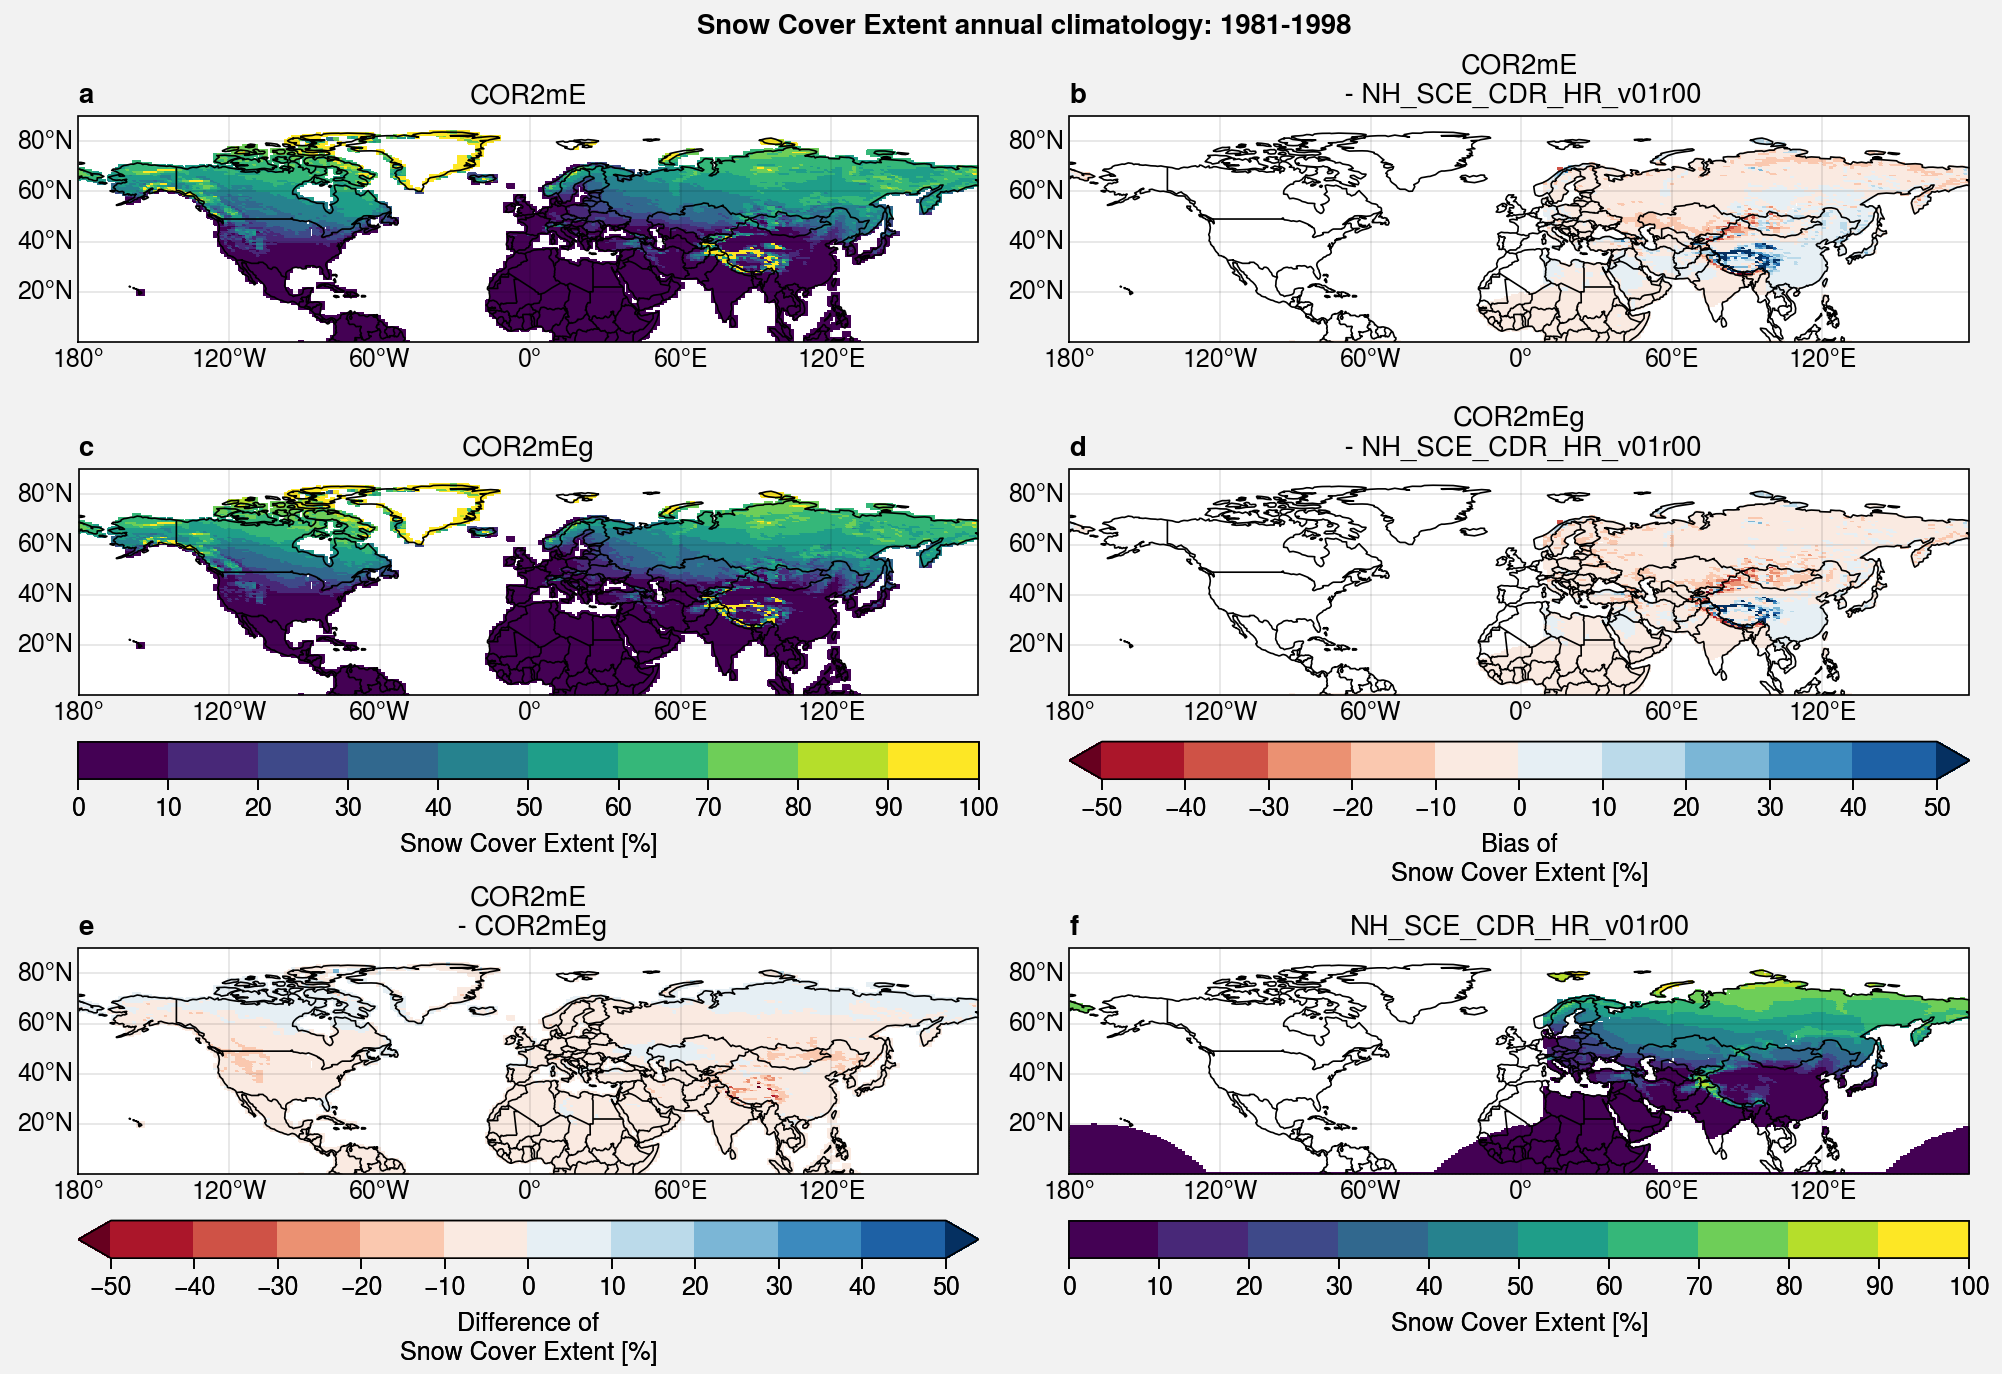

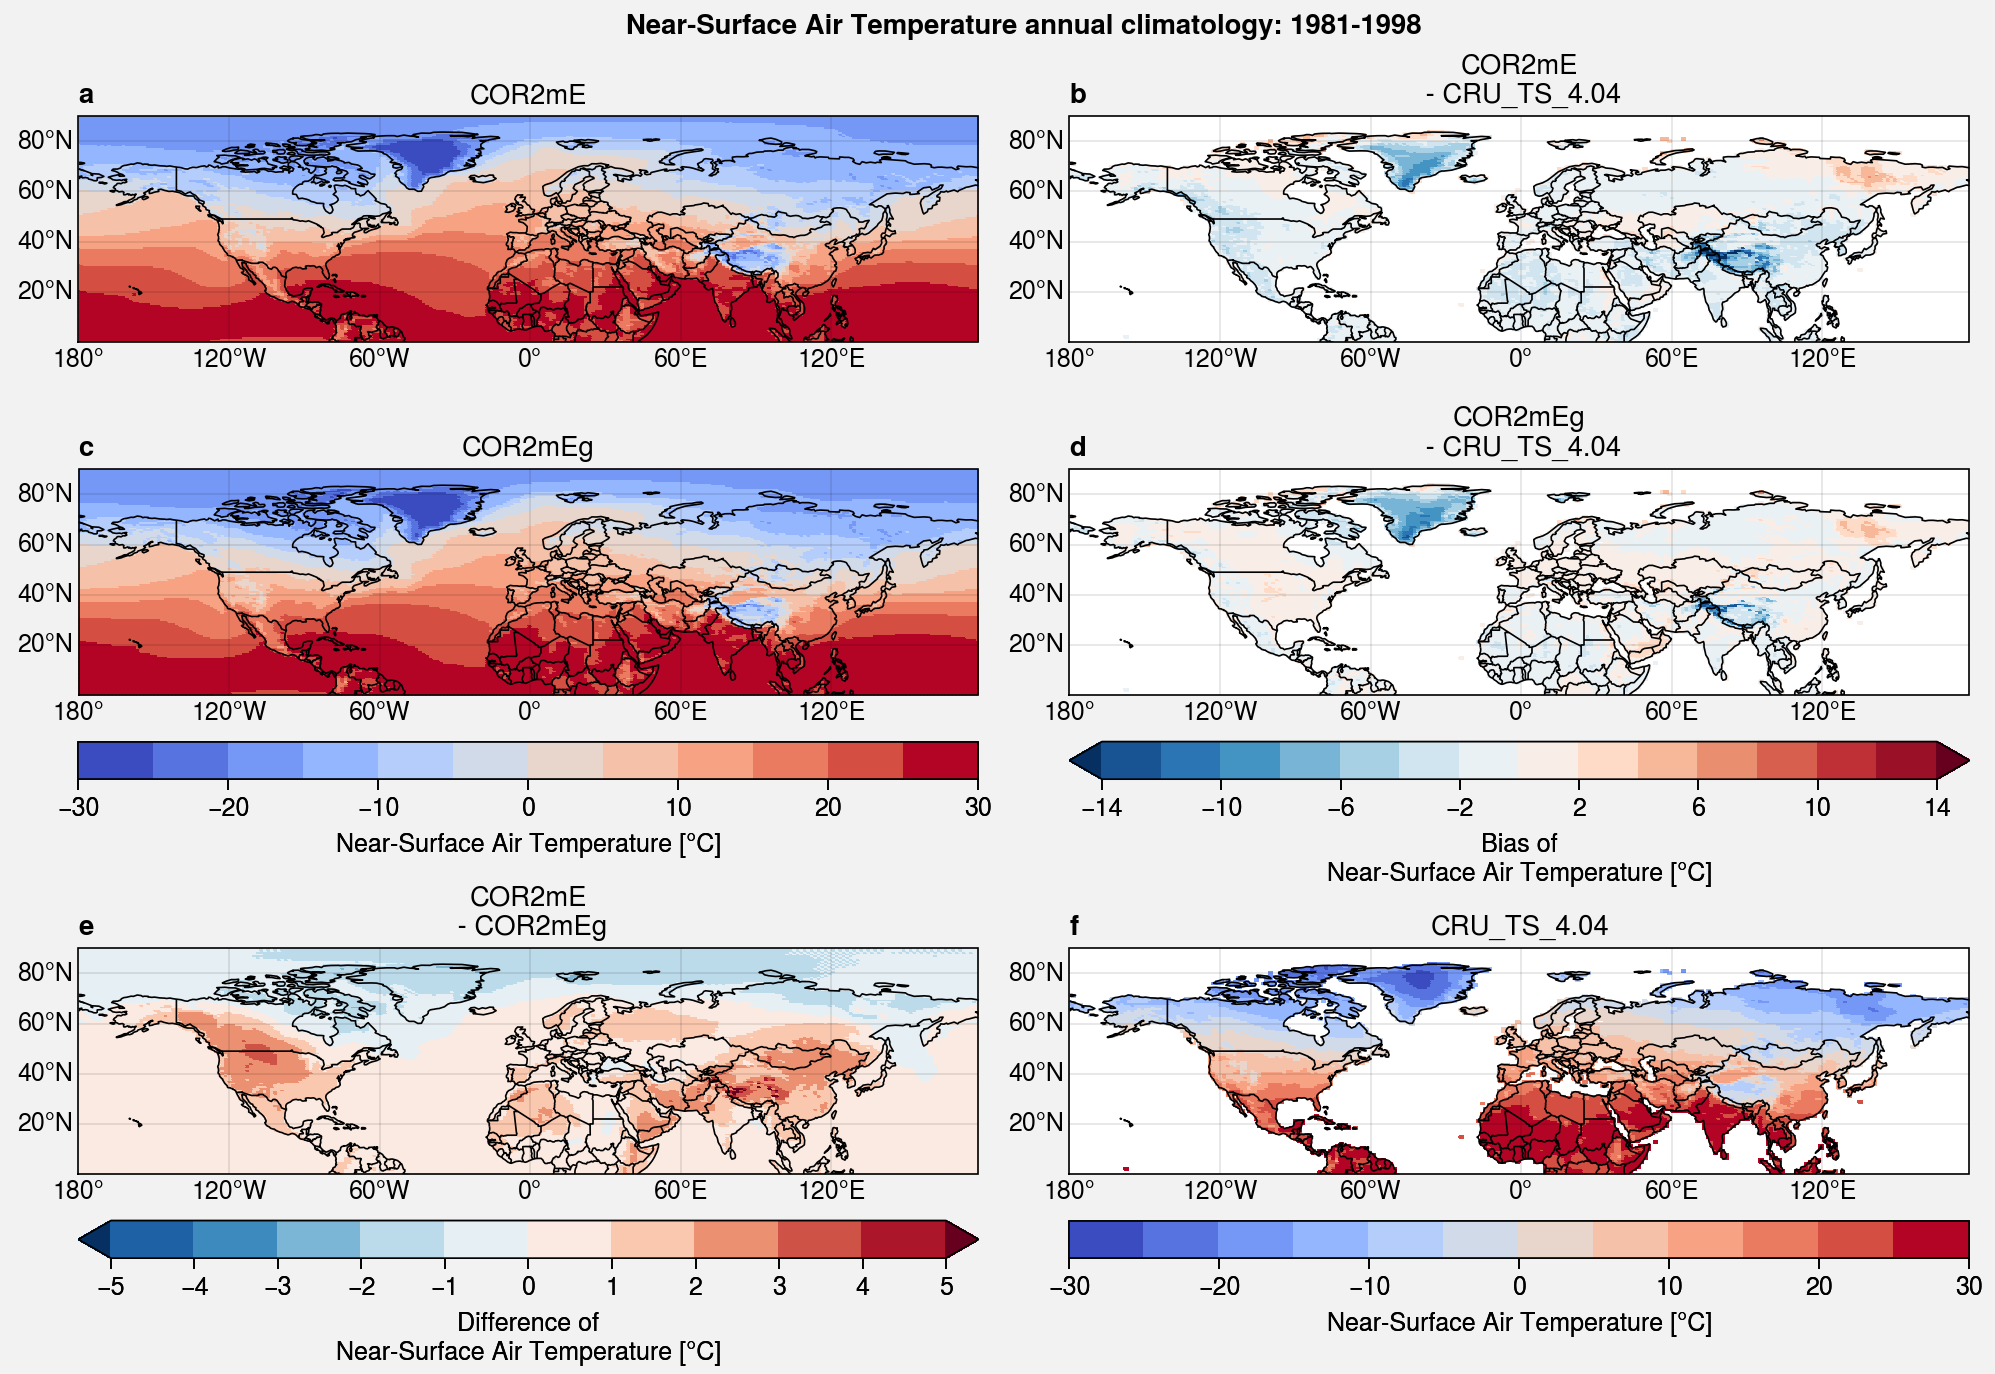

In [13]:
for i, var in enumerate(list_vars):
    label, units, \
    levels, cmap, extend, \
    levels_diff, cmap_diff, extend_diff, \
    levels_bias, cmap_bias, extend_bias = u.get_var_infos(var)

    u.plot_ref_new_obs(
        var, list_clim_ref[i], list_clim_new[i], list_clim_obs[i], label, units,
        levels, cmap, extend,
        levels_diff, cmap_diff, extend_diff,
        levels_bias, cmap_bias, extend_bias,
        save=False, dpi=300
    )

## Check correlation with topo

In [23]:
latlim, lonlim = u.get_domain_HMA()
latlim_ext, lonlim_ext = slice(latlim.start-5, latlim.stop+5), slice(lonlim.start-5, lonlim.stop+5)

ds = xr.open_dataset('/data/mlalande/Relief/GMTED2010_15n240_1000deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext, lon=lonlim_ext)
elevation = ds.elevation
elevation_std = ds.elevation_stddev

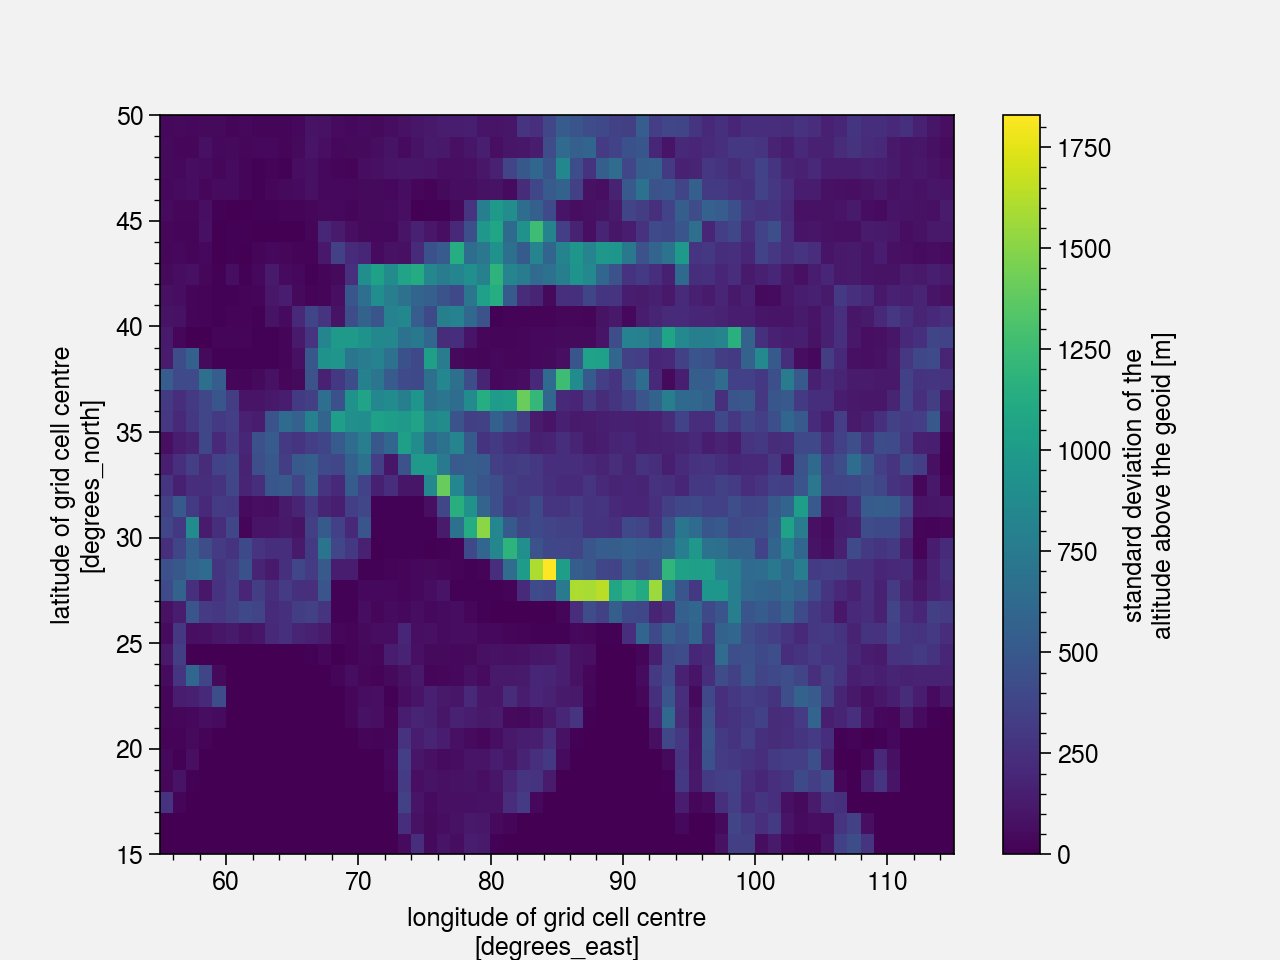

In [20]:
elevation_std.plot()

In [24]:
elevation_std_regrid = u.regrid(elevation_std, list_ref[0], globe=False, periodic=False)
elevation_regrid = u.regrid(elevation, list_ref[0], globe=False, periodic=False)

Reuse existing file: bilinear_35x60_257x256.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Reuse existing file: bilinear_35x60_257x256.nc


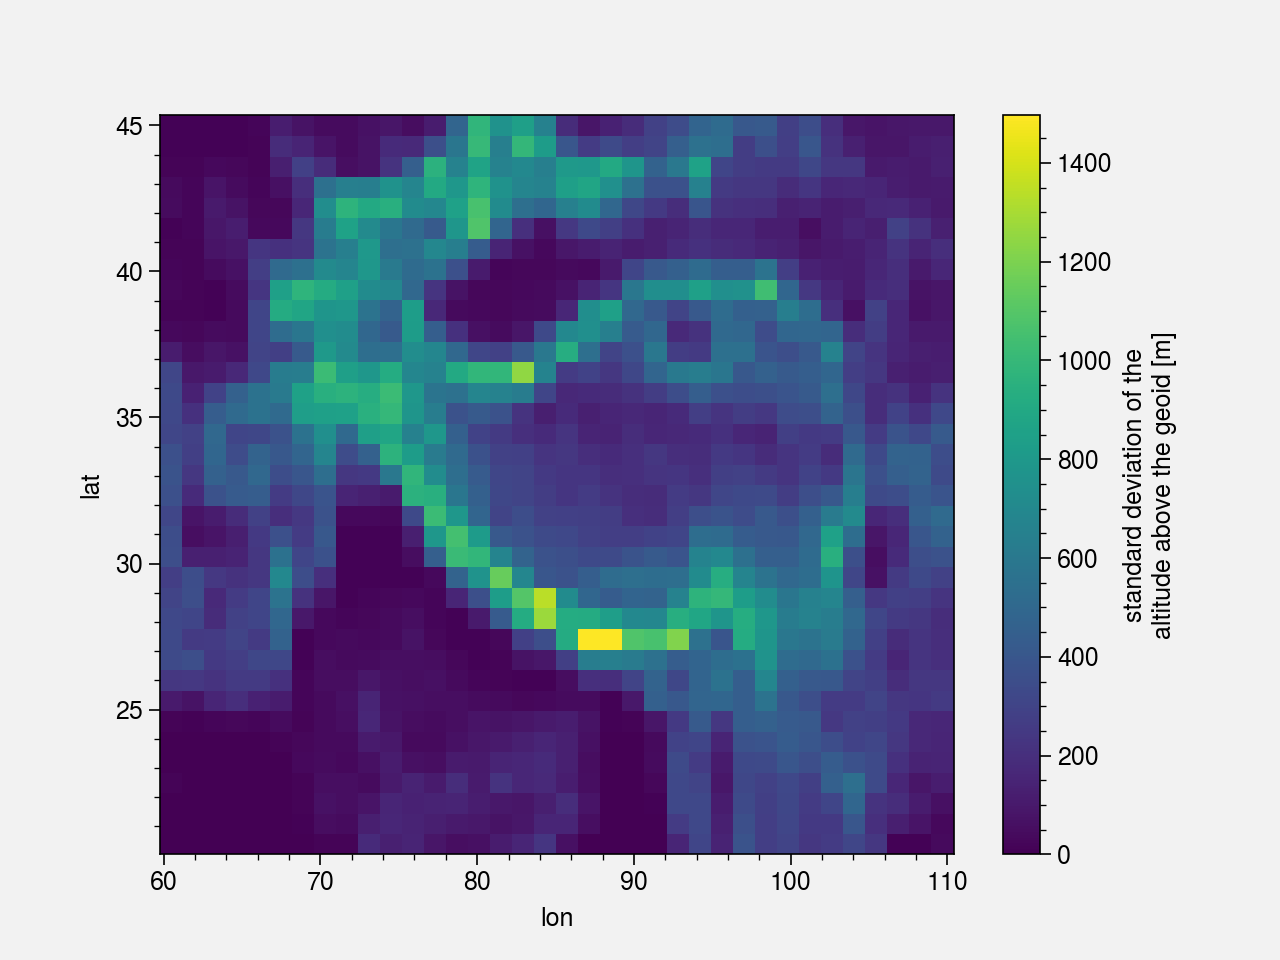

In [40]:
elevation_std_regrid.sel(lon=lonlim, lat=latlim).plot()

In [43]:
std = elevation_std_regrid.sel(lon=lonlim, lat=latlim).values.flatten()
topo = elevation_regrid.sel(lon=lonlim, lat=latlim).values.flatten()
ref_snc = (list_clim_ref[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).values.flatten()
new_snc = (list_clim_new[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).values.flatten()
ref_tas = (list_clim_ref[1] - list_clim_obs[1]).sel(lon=lonlim, lat=latlim).values.flatten()
new_tas = (list_clim_new[1] - list_clim_obs[1]).sel(lon=lonlim, lat=latlim).values.flatten()
ref_pr = (list_clim_ref[2] - list_clim_obs[2]).sel(lon=lonlim, lat=latlim).values.flatten()
new_pr = (list_clim_new[2] - list_clim_obs[2]).sel(lon=lonlim, lat=latlim).values.flatten()

std = np.array(std)
topo = np.array(topo)
ref_snc = np.array(ref_snc)
new_snc = np.array(new_snc)
ref_tas = np.array(ref_tas)
new_tas = np.array(new_tas)
ref_pr = np.array(ref_pr)
new_pr = np.array(new_pr)

# Remove NaNs (because of ocean)
std = std[~np.isnan(ref_snc)]
topo = topo[~np.isnan(ref_snc)]
new_snc = new_snc[~np.isnan(ref_snc)]
new_tas = new_tas[~np.isnan(ref_snc)]
ref_tas = ref_tas[~np.isnan(ref_snc)]
new_pr = new_tas[~np.isnan(ref_snc)]
ref_pr = ref_tas[~np.isnan(ref_snc)]

ref_snc = ref_snc[~np.isnan(ref_snc)]


std = std[~np.isnan(ref_tas)]
topo = topo[~np.isnan(ref_tas)]
new_snc = new_snc[~np.isnan(ref_tas)]
new_tas = new_tas[~np.isnan(ref_tas)]
ref_snc = ref_snc[~np.isnan(ref_tas)]
new_pr = new_tas[~np.isnan(ref_tas)]
ref_pr = ref_tas[~np.isnan(ref_tas)]

ref_tas = ref_tas[~np.isnan(ref_tas)]


print(len(std))
print(len(topo))
print(len(new_snc))
print(len(ref_snc))
print(len(new_tas))
print(len(ref_tas))
print(len(new_pr))
print(len(ref_pr))

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1225 but corresponding boolean dimension is 1296

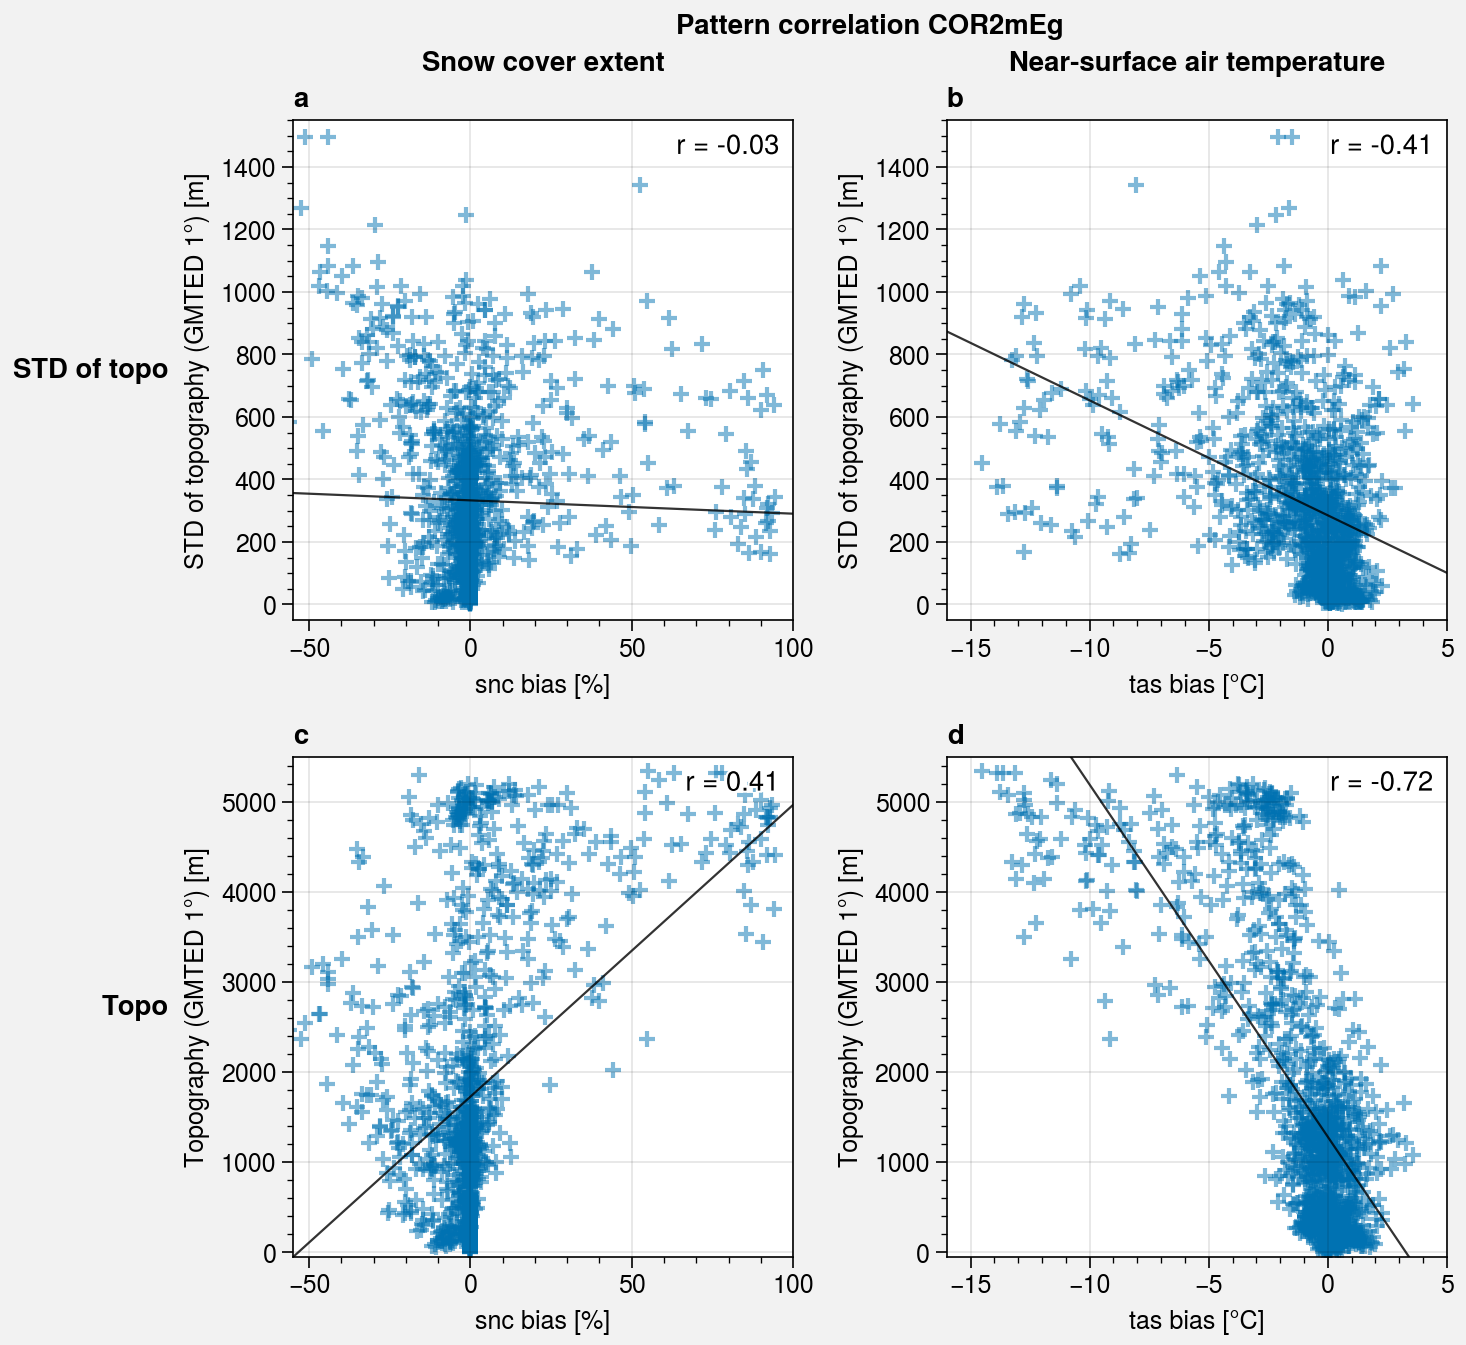

In [33]:
xlim_snc = (-55,100)
xlim_tas = (-16,5)
ylim_std = (-50,1550)
ylim_topo = (-50,5500)

fig, axs = plot.subplots(ncols=2, nrows=2, share=0)

###########
### std snc ###
###########

# Scatter plot
axs[0].scatter(new_snc, std, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_snc, std)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[0].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[0].format(
    urtitle='r = '+'{:.2f}'.format(reg.rvalue),
    xlabel='snc bias [%]', ylabel='STD of topography (GMTED 1°) [m]', 
    ylim=ylim_std, xlim=xlim_snc
)

###########
### std tas ###
###########

# Scatter plot
axs[1].scatter(new_tas, std, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_tas, std)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[1].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[1].format(
    urtitle='r = '+'{:.2f}'.format(reg.rvalue),
    xlabel='tas bias [°C]', ylabel='STD of topography (GMTED 1°) [m]', 
    ylim=ylim_std, xlim=xlim_tas
)


###########
### topo snc ###
###########

# Scatter plot
axs[2].scatter(new_snc, topo, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_snc, topo)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[2].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[2].format(
    urtitle='r = '+'{:.2f}'.format(reg.rvalue),
    xlabel='snc bias [%]', ylabel='Topography (GMTED 1°) [m]', 
    ylim=ylim_topo, xlim=xlim_snc
)

###########
### topo tas ###
###########

# Scatter plot
axs[3].scatter(new_tas, topo, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_tas, topo)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[3].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[3].format(
    urtitle='r = '+'{:.2f}'.format(reg.rvalue),
    xlabel='tas bias [°C]', ylabel='Topography (GMTED 1°) [m]', 
    ylim=ylim_topo, xlim=xlim_tas
)

##############
### Format ###
##############

axs.format(
    suptitle='Pattern correlation '+exp_new,
    collabels=['Snow cover extent', 'Near-surface air temperature'],
    rowlabels=['STD of topo', 'Topo'],
    abc=True
)

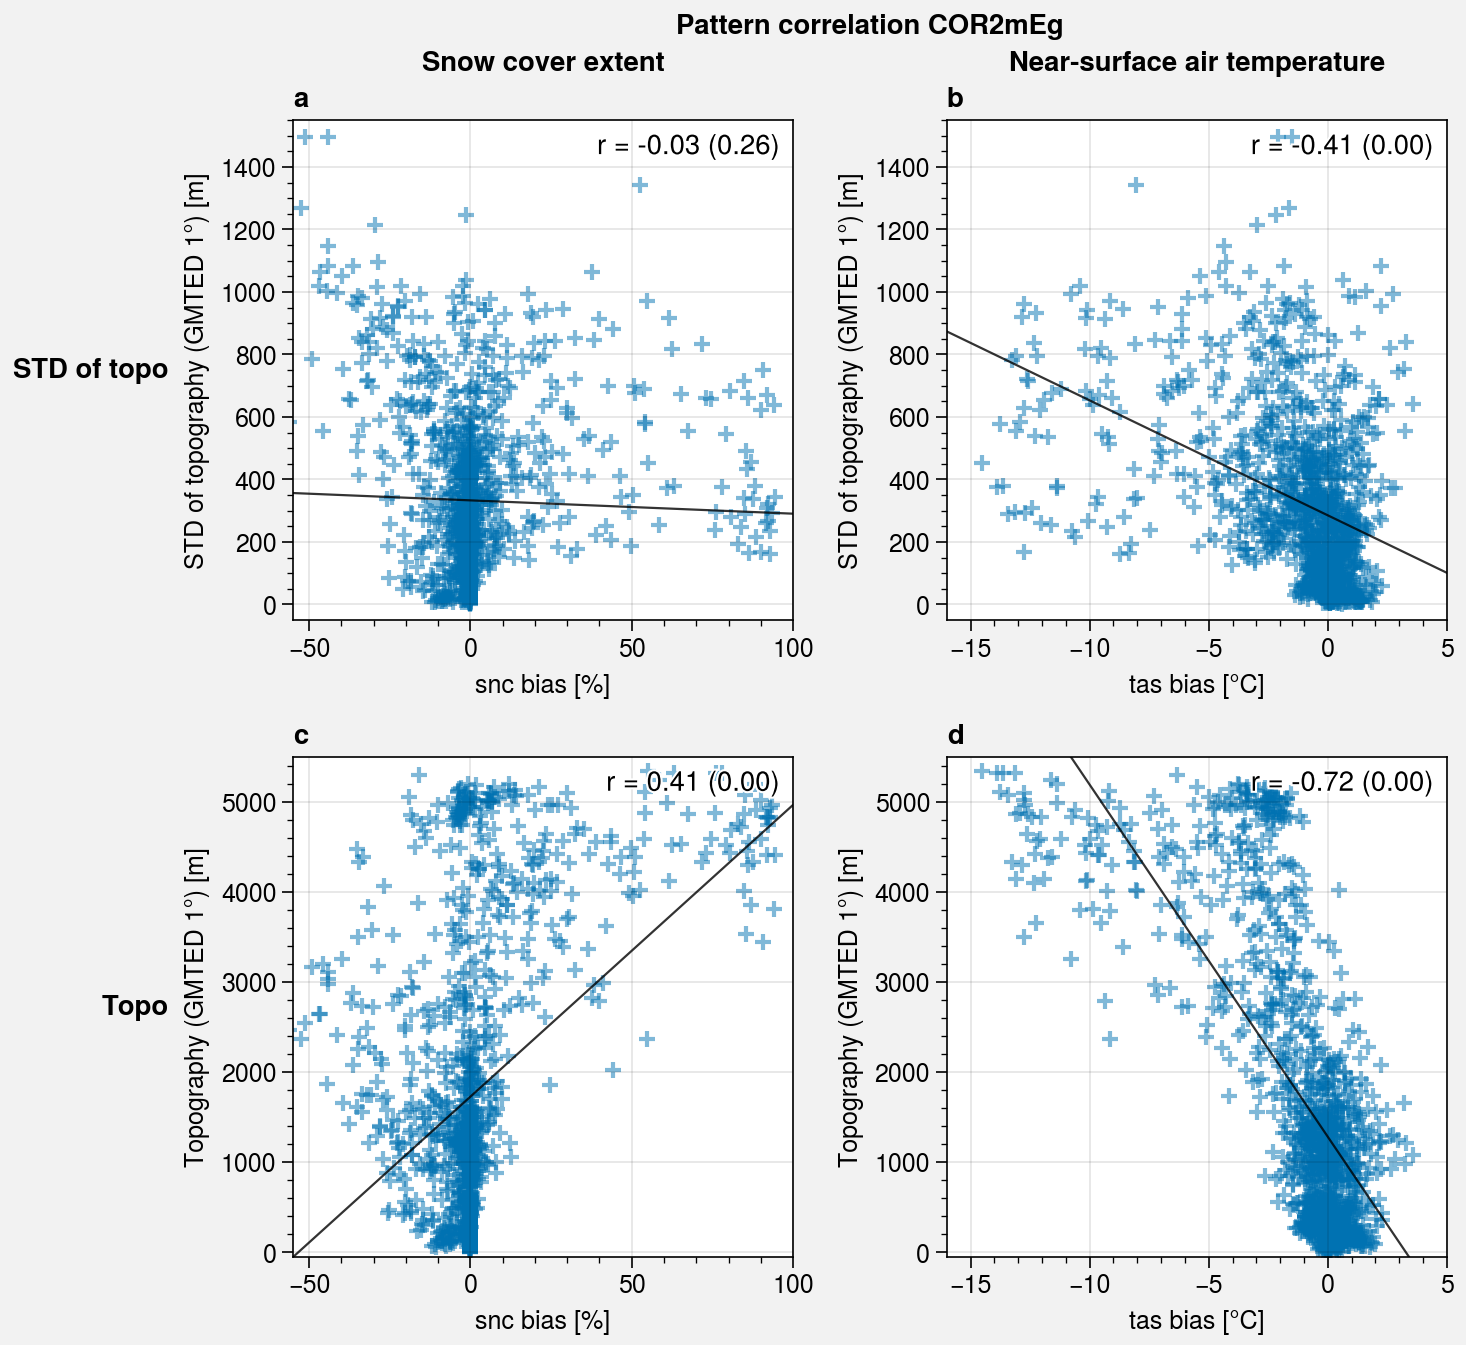

In [38]:
xlim_snc = (-55,100)
xlim_tas = (-16,5)
ylim_std = (-50,1550)
ylim_topo = (-50,5500)

fig, axs = plot.subplots(ncols=2, nrows=2, share=0)

###########
### std snc ###
###########

# Scatter plot
axs[0].scatter(new_snc, std, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_snc, std)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[0].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[0].format(
    urtitle='r = {:.2f}'.format(reg.rvalue) + ' ({:.2f}'.format(reg.pvalue)+')',
    xlabel='snc bias [%]', ylabel='STD of topography (GMTED 1°) [m]', 
    ylim=ylim_std, xlim=xlim_snc
)

###########
### std tas ###
###########

# Scatter plot
axs[1].scatter(new_tas, std, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_tas, std)
corr = stats.pearsonr(new_tas, std)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[1].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[1].format(
    urtitle='r = {:.2f}'.format(reg.rvalue) + ' ({:.2f}'.format(reg.pvalue)+')',
    xlabel='tas bias [°C]', ylabel='STD of topography (GMTED 1°) [m]', 
    ylim=ylim_std, xlim=xlim_tas
)


###########
### topo snc ###
###########

# Scatter plot
axs[2].scatter(new_snc, topo, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_snc, topo)
corr = stats.pearsonr(new_snc, topo)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[2].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[2].format(
    urtitle='r = {:.2f}'.format(reg.rvalue) + ' ({:.2f}'.format(reg.pvalue)+')',
    xlabel='snc bias [%]', ylabel='Topography (GMTED 1°) [m]', 
    ylim=ylim_topo, xlim=xlim_snc
)

###########
### topo tas ###
###########

# Scatter plot
axs[3].scatter(new_tas, topo, marker='+', alpha=0.5)

# Regression
reg = stats.linregress(new_tas, topo)
corr = stats.pearsonr(new_tas, topo)
x = np.array(xlim)
y = reg.slope*x + reg.intercept
axs[3].plot(x, y, 'k-', linewidth=0.8, alpha=0.8)

# Format
axs[3].format(
    urtitle='r = {:.2f}'.format(reg.rvalue) + ' ({:.2f}'.format(reg.pvalue)+')',
    xlabel='tas bias [°C]', ylabel='Topography (GMTED 1°) [m]', 
    ylim=ylim_topo, xlim=xlim_tas
)

##############
### Format ###
##############

axs.format(
    suptitle='Pattern correlation '+exp_new,
    collabels=['Snow cover extent', 'Near-surface air temperature'],
    rowlabels=['STD of topo', 'Topo'],
    abc=True
)

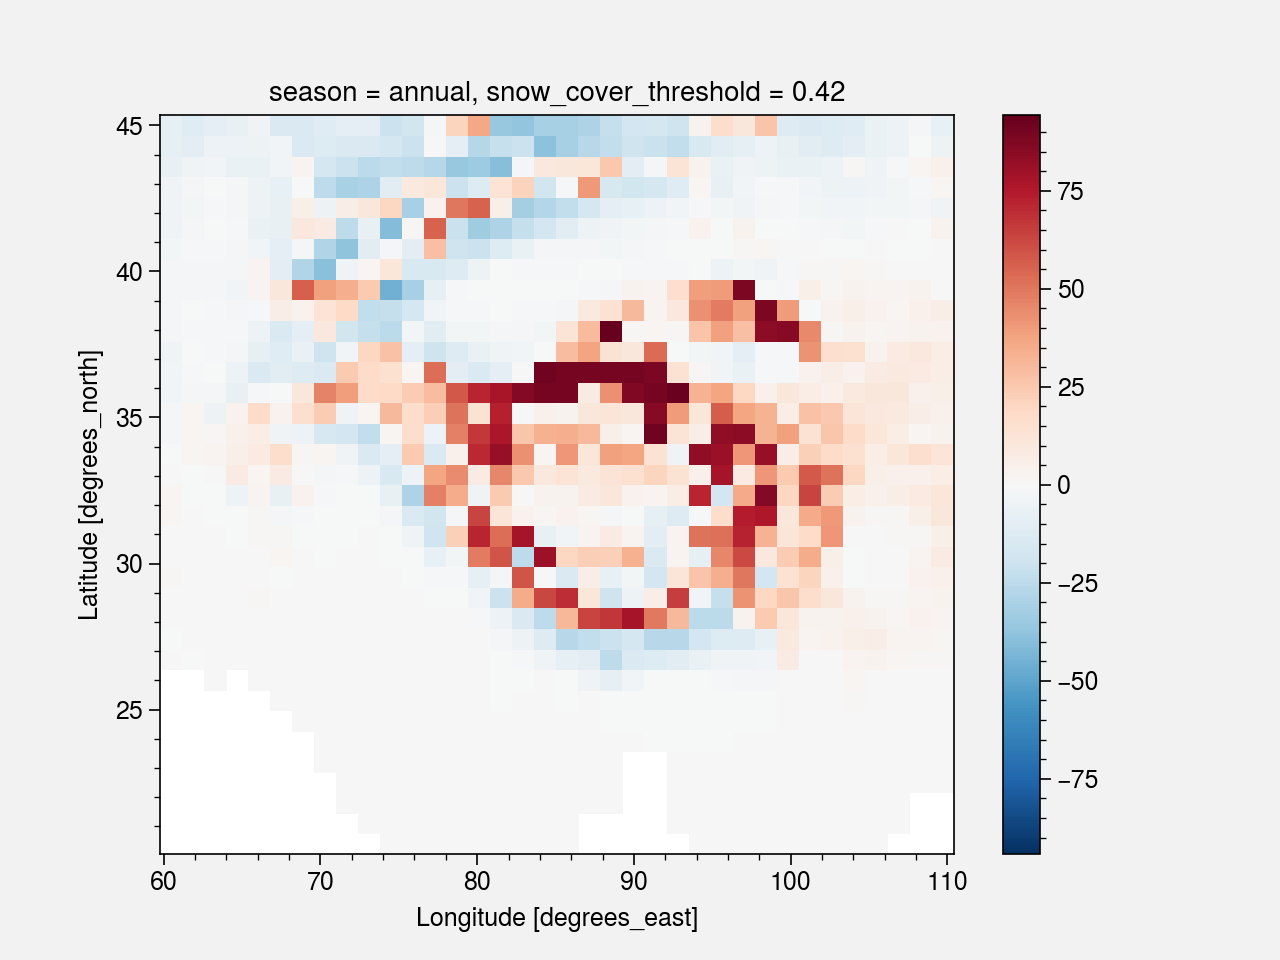

In [36]:
(list_clim_ref[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).plot()

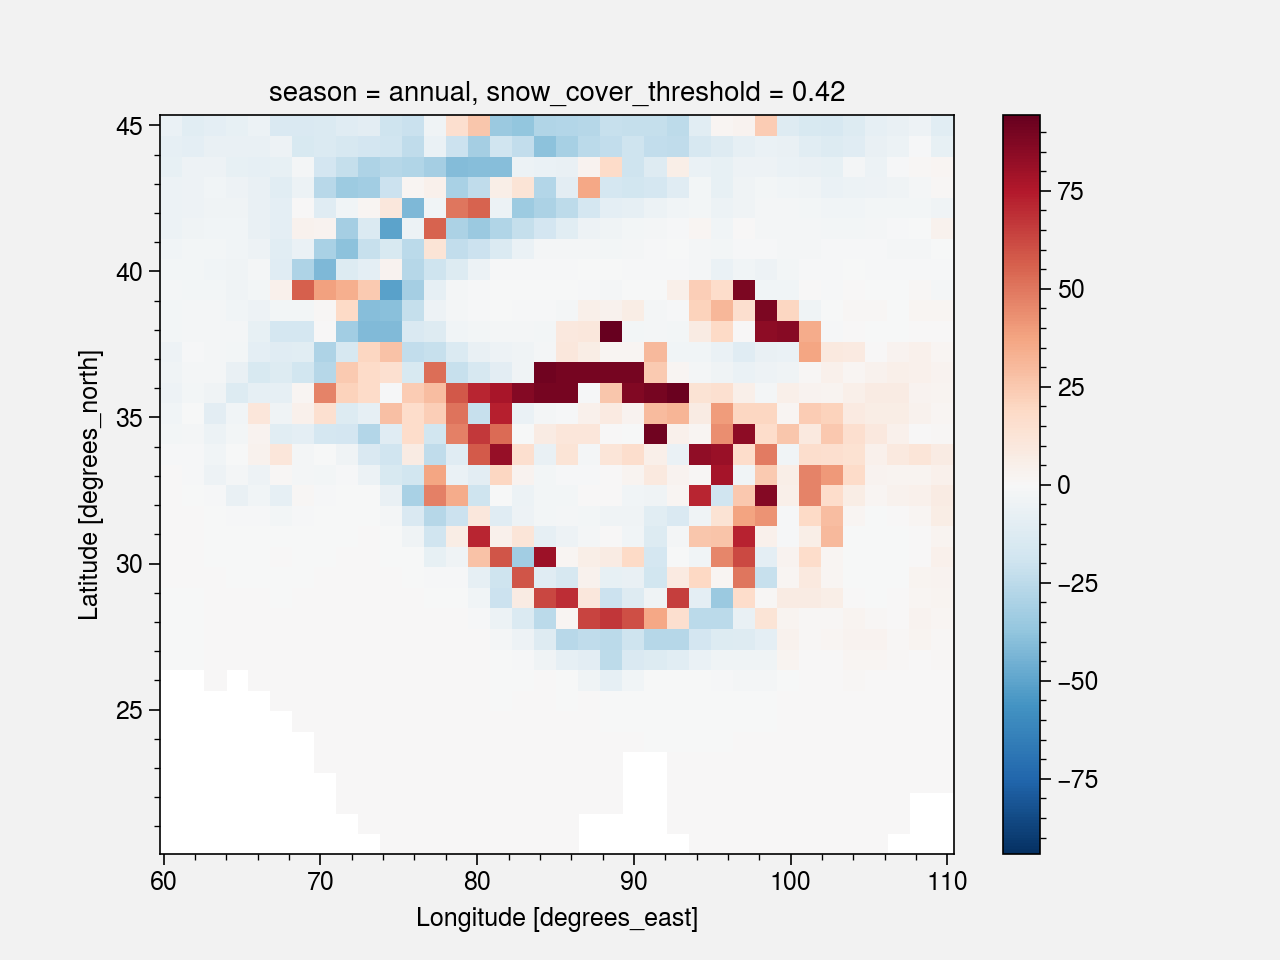

In [37]:
(list_clim_new[0] - list_clim_obs[0]).sel(lon=lonlim, lat=latlim).plot()

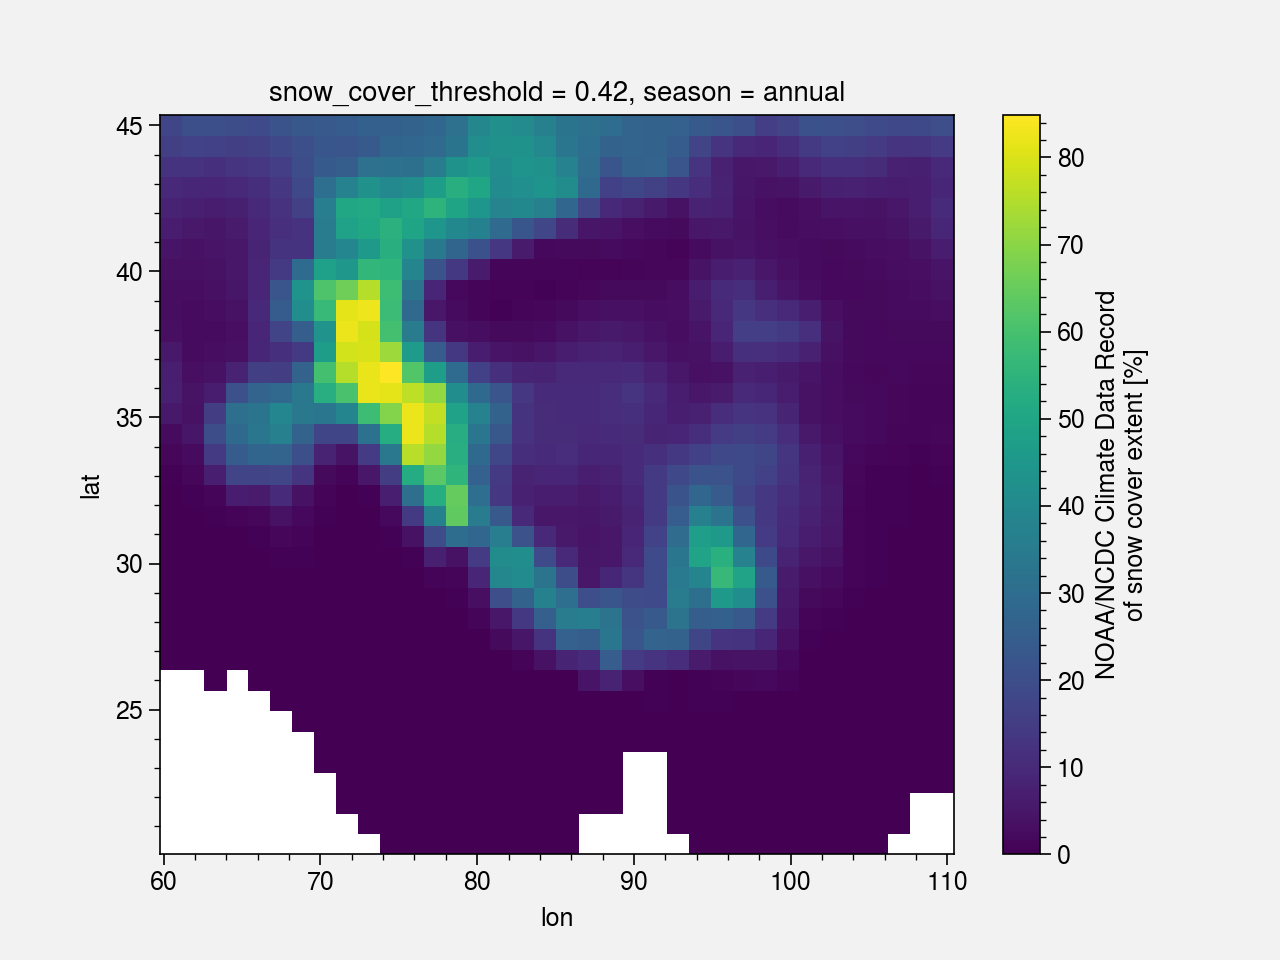

In [35]:
list_clim_obs[0].sel(lon=lonlim, lat=latlim).plot()